# Speech-to-Text Russian Dataset EDA

Этот notebook предназначен для исследования данных Mozilla Common Voice и подготовки к обучению модели speech-to-text для русского языка.

## План анализа

1. **Загрузка и первичный анализ данных**
   - Загрузка Mozilla Common Voice для русского языка
   - Общая статистика датасета
   - Распределение данных по splits

2. **Анализ аудио данных**
   - Распределение длительности аудиозаписей
   - Качество аудио и частота дискретизации
   - Анализ амплитуды и спектрограмм

3. **Анализ текстовых данных**
   - Длина текстов и распределение слов
   - Частотный анализ слов
   - Уникальные символы и словарь

4. **Качество данных**
   - Пропуски и аномалии
   - Соответствие аудио и текста
   - Рекомендации по фильтрации

5. **Подготовка к обучению**
   - Тестирование DataLoader
   - Проверка preprocessor'а
   - Размер батчей и memory usage


In [1]:
# Импорты и настройка
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print(f"📁 Project root: {project_root}")
print(f"📁 Current working directory: {Path.cwd()}")
print(f"🔍 Python path includes: {str(project_root)}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import torch
import torchaudio
import torchaudio.transforms as T
from IPython.display import Audio, display
import ipywidgets as widgets

# Настройка графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🎵 Speech-to-Text EDA Setup Complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Проверка audio backend
print(f"\n🔊 TorchAudio version: {torchaudio.__version__}")
available_backends = torchaudio.list_audio_backends()
print(f"Available audio backends: {available_backends}")
if 'ffmpeg' in available_backends:
    print("✅ FFmpeg backend available - MP3/MP4 support enabled")
else:
    print("⚠️  FFmpeg backend not found - install with: conda install -n basenn -c conda-forge ffmpeg -y")


📁 Project root: c:\Users\User\Documents\Progs\Projects\seepch_to_text
📁 Current working directory: c:\Users\User\Documents\Progs\Projects\seepch_to_text\notebooks
🔍 Python path includes: c:\Users\User\Documents\Progs\Projects\seepch_to_text
🎵 Speech-to-Text EDA Setup Complete!
PyTorch version: 2.5.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4070 Ti

🔊 TorchAudio version: 2.5.1
Available audio backends: ['ffmpeg', 'soundfile']
✅ FFmpeg backend available - MP3/MP4 support enabled


In [2]:
# Загрузка конфигурации проекта

# Импорты с использованием централизованного управления путями
print("🔧 Импорт модулей проекта...")
try:
    from src.config import load_config, ProjectConfig
    from src.data import DataManager
    from src.utils import PROJECT_ROOT, get_project_root, get_data_dir, get_config_dir
    print("✅ Все модули импортированы успешно!")
    
    print(f"\n📁 Пути из utils:")
    print(f"  PROJECT_ROOT: {PROJECT_ROOT}")
    print(f"  Data dir: {get_data_dir()}")
    print(f"  Config dir: {get_config_dir()}")
    
except ImportError as e:
    print(f"❌ Ошибка импорта: {e}")
    print("💡 Перезапустите ядро Jupyter: Kernel -> Restart Kernel")
    raise

# Загружаем конфигурацию используя централизованные пути
config_path = get_config_dir() / "default.yaml"
print(f"📄 Loading config from: {config_path}")

if config_path.exists():
    config = load_config(str(config_path))
    print("✅ Configuration loaded successfully!")
else:
    print(f"❌ Config file not found at: {config_path}")
    print("Available config files:")
    config_dir = get_config_dir()
    if config_dir.exists():
        for cfg_file in config_dir.glob("*.yaml"):
            print(f"  - {cfg_file.name}")
    raise FileNotFoundError(f"Config file not found: {config_path}")

# Инициализируем data manager
data_manager = DataManager(config)
print("✅ Data manager initialized!")

# Проверяем статус локального датасета (Common Voice 22.0)
print("\n🔍 Checking local dataset status...")
dataset_info = data_manager.get_dataset_info()

if dataset_info["status"] == "available":
    print(f"✅ Local dataset available at: {dataset_info['local_path']}")
    print(f"📊 Total samples: {dataset_info['total_samples']:,}")
    print(f"📊 Dataset version: {dataset_info['dataset_version']}")
    print(f"🌍 Language: {dataset_info['language']}")
    print("🚀 Ready for offline data analysis!")
    
    # Показываем информацию по splits
    print("\n📋 Split information:")
    for split_name, split_info in dataset_info["splits"].items():
        if "num_samples" in split_info:
            print(f"  {split_name}: {split_info['num_samples']:,} samples")
elif dataset_info["status"] == "not_available":
    print("❌ No local dataset found!")
    print("📥 Please download Mozilla Common Voice 22.0 dataset:")
    print("   1. Go to: https://commonvoice.mozilla.org/en/datasets")
    print("   2. Download Russian (ru) dataset") 
    print("   3. Extract to: data/cv-corpus-22.0-2025-06-20/")
    print("\n⚠️  This notebook requires local dataset to work")
    raise RuntimeError("Local dataset not found. Please download Common Voice 22.0 manually.")
else:
    print(f"❌ Dataset error: {dataset_info.get('error', 'Unknown')}")
    raise RuntimeError(f"Dataset error: {dataset_info.get('error', 'Unknown')}")


🔧 Импорт модулей проекта...
✅ Все модули импортированы успешно!

📁 Пути из utils:
  PROJECT_ROOT: C:\Users\User\Documents\Progs\Projects\seepch_to_text
  Data dir: C:\Users\User\Documents\Progs\Projects\seepch_to_text\data
  Config dir: C:\Users\User\Documents\Progs\Projects\seepch_to_text\configs
📄 Loading config from: C:\Users\User\Documents\Progs\Projects\seepch_to_text\configs\default.yaml
✅ Configuration loaded successfully!
✅ Data manager initialized!

🔍 Checking local dataset status...
✅ Local dataset available at: C:\Users\User\Documents\Progs\Projects\seepch_to_text\data\cv-corpus-22.0-2025-06-20\ru
📊 Total samples: 47,141
📊 Dataset version: Common Voice 22.0
🌍 Language: ru
🚀 Ready for offline data analysis!

📋 Split information:
  train: 26,654 samples
  dev: 10,243 samples
  test: 10,244 samples


In [3]:
# Загрузка Mozilla Common Voice Dataset TSV для анализа
print("🔄 Loading Mozilla Common Voice dataset from TSV files...")
print("This loads metadata quickly - audio files are accessed on demand...")

# Загружаем все splits как pandas DataFrames
train_df = data_manager.load_dataset("train")
val_df = data_manager.load_dataset("dev") 
test_df = data_manager.load_dataset("test")

print(f"✅ Dataset metadata loaded successfully!")
print(f"📊 Train samples: {len(train_df):,}")
print(f"📊 Validation samples: {len(val_df):,}")
print(f"📊 Test samples: {len(test_df):,}")
print(f"📊 Total samples: {len(train_df) + len(val_df) + len(test_df):,}")

# Показываем структуру TSV данных
print(f"\n📋 TSV columns: {list(train_df.columns)}")
print(f"📋 Sample train entry:")
display(train_df.head(3))

🔄 Loading Mozilla Common Voice dataset from TSV files...
This loads metadata quickly - audio files are accessed on demand...
✅ Dataset metadata loaded successfully!
📊 Train samples: 26,654
📊 Validation samples: 10,243
📊 Test samples: 10,244
📊 Total samples: 47,141

📋 TSV columns: ['client_id', 'path', 'sentence_id', 'sentence', 'sentence_domain', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'duration']
📋 Sample train entry:


,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,duration
0,81dd83a503a8d2ce306a700841ec1fd7a2808036310fab...,common_voice_ru_30446639.mp3,f182ab6980234bd184311a66c58b0db81707f552e70ad8...,Она увидала мужа еще издалека.,NaN,2,1,NaN,NaN,NaN,NaN,ru,NaN,4.068
1,81dd83a503a8d2ce306a700841ec1fd7a2808036310fab...,common_voice_ru_30446640.mp3,9da462cc0fa1f0569e8df8d4bc699b8bd3b7e29e0da69b...,Но Кити не слушала ее слов.,NaN,2,0,NaN,NaN,NaN,NaN,ru,NaN,3.924
2,81dd83a503a8d2ce306a700841ec1fd7a2808036310fab...,common_voice_ru_30446644.mp3,e9789af8ae48240cec21b8cdd4ed01314de5f055e30f37...,"Ну, как мой приятель относится?",NaN,2,0,NaN,NaN,NaN,NaN,ru,NaN,3.384


In [4]:
# 1. ОБЩАЯ СТАТИСТИКА ДАТАСЕТА
print("🔍 Dataset Structure Analysis")
print("=" * 60)

# Базовая информация
print("📊 Dataset Overview:")
print(f"  📁 Total files: {len(train_df) + len(val_df) + len(test_df):,}")
print(f"  🏋️ Train: {len(train_df):,} ({len(train_df)/(len(train_df) + len(val_df) + len(test_df))*100:.1f}%)")
print(f"  ✅ Validation: {len(val_df):,} ({len(val_df)/(len(train_df) + len(val_df) + len(test_df))*100:.1f}%)")
print(f"  🧪 Test: {len(test_df):,} ({len(test_df)/(len(train_df) + len(val_df) + len(test_df))*100:.1f}%)")

# Проверяем columns
print(f"\n📋 Available columns in TSV:")
for col in train_df.columns:
    print(f"  - {col}")

# Статистика по голосам (если есть client_id)
if 'client_id' in train_df.columns:
    unique_speakers_train = train_df['client_id'].nunique()
    unique_speakers_val = val_df['client_id'].nunique() 
    unique_speakers_test = test_df['client_id'].nunique()
    
    print(f"\n🎤 Speaker Statistics:")
    print(f"  Train speakers: {unique_speakers_train:,}")
    print(f"  Val speakers: {unique_speakers_val:,}")
    print(f"  Test speakers: {unique_speakers_test:,}")
    print(f"  Total unique speakers: {pd.concat([train_df, val_df, test_df])['client_id'].nunique():,}")

# Статистика голосования (если есть up_votes, down_votes)
if 'up_votes' in train_df.columns:
    print(f"\n👍 Voting Statistics (Train set):")
    print(f"  Avg up votes: {train_df['up_votes'].mean():.2f}")
    print(f"  Avg down votes: {train_df['down_votes'].mean():.2f}")
    print(f"  Total validated: {(train_df['up_votes'] > train_df['down_votes']).sum():,}")
    print(f"  Validation rate: {(train_df['up_votes'] > train_df['down_votes']).mean()*100:.1f}%")


🔍 Dataset Structure Analysis
📊 Dataset Overview:
  📁 Total files: 47,141
  🏋️ Train: 26,654 (56.5%)
  ✅ Validation: 10,243 (21.7%)
  🧪 Test: 10,244 (21.7%)

📋 Available columns in TSV:
  - client_id
  - path
  - sentence_id
  - sentence
  - sentence_domain
  - up_votes
  - down_votes
  - age
  - gender
  - accents
  - variant
  - locale
  - segment
  - duration

🎤 Speaker Statistics:
  Train speakers: 326
  Val speakers: 485
  Test speakers: 2,033
  Total unique speakers: 2,844

👍 Voting Statistics (Train set):
  Avg up votes: 2.50
  Avg down votes: 0.10
  Total validated: 26,654
  Validation rate: 100.0%


In [5]:
# 2. АНАЛИЗ АУДИО ДАННЫХ
print("🎵 Audio Data Analysis")
print("=" * 60)

# Используем предварительно рассчитанные длительности из DataFrame
# (они уже загружены из clip_durations.tsv или рассчитаны при загрузке датасета)
print("📊 Analyzing audio duration from cached data...")

# Получаем длительности напрямую из DataFrame
audio_durations_array = train_df['duration'].to_numpy()

print(f"✅ Analyzed {len(audio_durations_array)} audio files (from cached durations)")

# Статистика длительности
print(f"\n🎵 Audio Duration Statistics:")
print(f"  Mean: {audio_durations_array.mean():.2f} seconds")
print(f"  Median: {np.median(audio_durations_array):.2f} seconds")
print(f"  Min: {audio_durations_array.min():.2f} seconds")
print(f"  Max: {audio_durations_array.max():.2f} seconds")
print(f"  Std: {audio_durations_array.std():.2f} seconds")

# Проверяем sample rate одного файла (все файлы Common Voice имеют одинаковый sample rate)
sample_audio_path = data_manager.clips_dir / train_df.iloc[0]['path']
if sample_audio_path.exists():
    audio_info = torchaudio.info(str(sample_audio_path))
    print(f"\n🔊 Sample Rate: {audio_info.sample_rate} Hz (Common Voice standard)")
else:
    print(f"\n⚠️ Could not check sample rate - sample file not found")

# Оценка общего объема данных
total_duration_hours = audio_durations_array.sum() / 3600
print(f"\n📊 Total Train Duration: {total_duration_hours:.2f} hours")
print(f"📊 Average clip duration: {audio_durations_array.mean():.2f} seconds")


🎵 Audio Data Analysis
📊 Analyzing audio duration from cached data...
✅ Analyzed 26654 audio files (from cached durations)

🎵 Audio Duration Statistics:
  Mean: 5.15 seconds
  Median: 5.02 seconds
  Min: 1.08 seconds
  Max: 10.58 seconds
  Std: 1.77 seconds

🔊 Sample Rate: 32000 Hz (Common Voice standard)

📊 Total Train Duration: 38.12 hours
📊 Average clip duration: 5.15 seconds


📈 Audio Data Visualizations


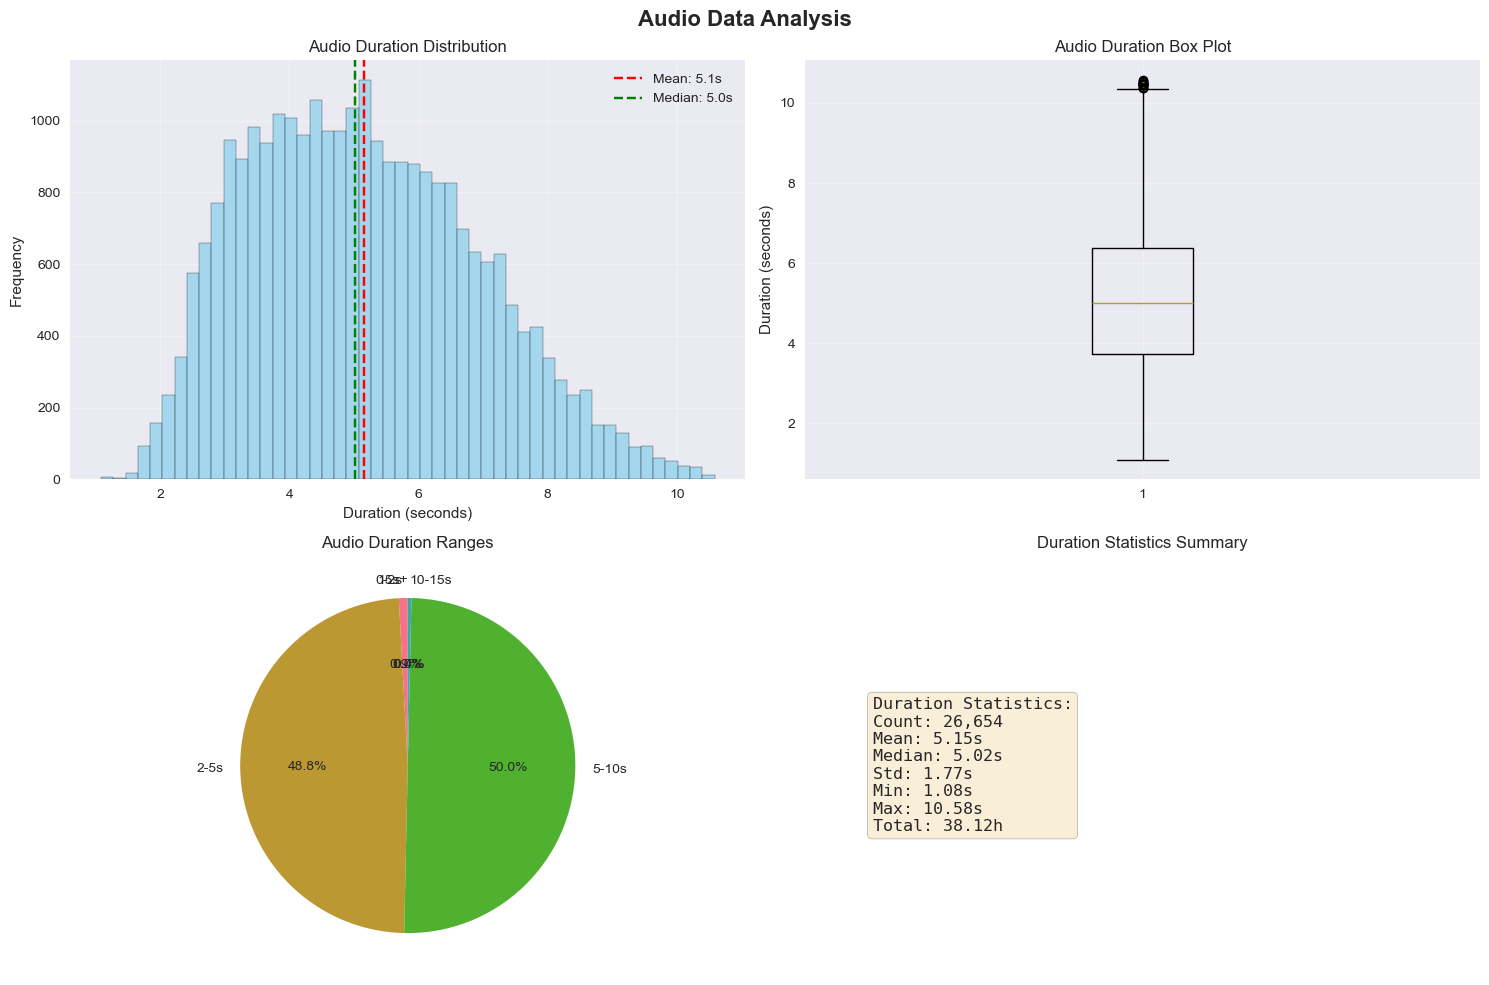

In [18]:
# Визуализация аудио данных
print("📈 Audio Data Visualizations")

# Создаем subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Audio Data Analysis', fontsize=16, fontweight='bold')

# 1. Гистограмма длительности
axes[0, 0].hist(audio_durations_array, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(audio_durations_array.mean(), color='red', linestyle='--', label=f'Mean: {audio_durations_array.mean():.1f}s')
axes[0, 0].axvline(np.median(audio_durations_array), color='green', linestyle='--', label=f'Median: {np.median(audio_durations_array):.1f}s')
axes[0, 0].set_xlabel('Duration (seconds)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Audio Duration Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot длительности
axes[0, 1].boxplot(audio_durations_array, vert=True)
axes[0, 1].set_ylabel('Duration (seconds)')
axes[0, 1].set_title('Audio Duration Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Распределение по диапазонам длительности 
duration_ranges = ['0-2s', '2-5s', '5-10s', '10-15s', '15s+']
duration_counts = [
    (audio_durations_array <= 2).sum(),
    ((audio_durations_array > 2) & (audio_durations_array <= 5)).sum(),
    ((audio_durations_array > 5) & (audio_durations_array <= 10)).sum(), 
    ((audio_durations_array > 10) & (audio_durations_array <= 15)).sum(),
    (audio_durations_array > 15).sum()
]

axes[1, 0].pie(duration_counts, labels=duration_ranges, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Audio Duration Ranges')

# 4. Статистика по длительности
stats_text = f"""Duration Statistics:
Count: {len(audio_durations_array):,}
Mean: {audio_durations_array.mean():.2f}s
Median: {np.median(audio_durations_array):.2f}s
Std: {audio_durations_array.std():.2f}s
Min: {audio_durations_array.min():.2f}s
Max: {audio_durations_array.max():.2f}s
Total: {audio_durations_array.sum()/3600:.2f}h"""

axes[1, 1].text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center', 
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')
axes[1, 1].set_title('Duration Statistics Summary')

plt.tight_layout()
plt.show()

# Интерактивная визуализация с Plotly
fig_plotly = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Duration Distribution', 'Duration by Index', 
                   'Cumulative Duration', 'Duration Percentiles'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Гистограмма длительности
fig_plotly.add_trace(
    go.Histogram(x=audio_durations_array, nbinsx=50, name="Duration", opacity=0.7),
    row=1, col=1
)

# 2. Scatter plot длительность по индексу
fig_plotly.add_trace(
    go.Scatter(x=np.arange(len(audio_durations_array)), y=audio_durations_array, 
              mode='markers', name="Duration", opacity=0.3, marker=dict(size=3)),
    row=1, col=2
)

# 3. Кумулятивное распределение
sorted_durations = np.sort(audio_durations_array)
cumulative = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations) * 100
fig_plotly.add_trace(
    go.Scatter(x=sorted_durations, y=cumulative, mode='lines', name="Cumulative %"),
    row=2, col=1
)

# 4. Percentiles
percentiles = [10, 25, 50, 75, 90, 95, 99]
percentile_values = [np.percentile(audio_durations_array, p) for p in percentiles]
fig_plotly.add_trace(
    go.Bar(x=[f'P{p}' for p in percentiles], y=percentile_values, name="Percentiles"),
    row=2, col=2
)

fig_plotly.update_xaxes(title_text="Duration (s)", row=1, col=1)
fig_plotly.update_xaxes(title_text="Sample Index", row=1, col=2)
fig_plotly.update_xaxes(title_text="Duration (s)", row=2, col=1)
fig_plotly.update_xaxes(title_text="Percentile", row=2, col=2)

fig_plotly.update_yaxes(title_text="Count", row=1, col=1)
fig_plotly.update_yaxes(title_text="Duration (s)", row=1, col=2)
fig_plotly.update_yaxes(title_text="Cumulative %", row=2, col=1)
fig_plotly.update_yaxes(title_text="Duration (s)", row=2, col=2)

fig_plotly.update_layout(height=800, showlegend=False, title_text="Interactive Audio Analysis")
fig_plotly.show()


In [19]:
# 3. АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ
print("📝 Text Data Analysis")
print("=" * 60)

# Объединяем все тексты для анализа
all_texts = pd.concat([train_df['sentence'], val_df['sentence'], test_df['sentence']])

# Базовая статистика по длине текстов
text_lengths = all_texts.str.len()
word_counts = all_texts.str.split().str.len()

print("📊 Text Length Statistics:")
print(f"  Character count:")
print(f"    Mean: {text_lengths.mean():.1f} chars")
print(f"    Median: {text_lengths.median():.1f} chars")
print(f"    Min: {text_lengths.min()} chars")
print(f"    Max: {text_lengths.max()} chars")
print(f"    Std: {text_lengths.std():.1f} chars")

print(f"\n  Word count:")
print(f"    Mean: {word_counts.mean():.1f} words")
print(f"    Median: {word_counts.median():.1f} words")
print(f"    Min: {word_counts.min()} words")
print(f"    Max: {word_counts.max()} words")
print(f"    Std: {word_counts.std():.1f} words")

# Анализ уникальных символов
all_text_combined = ' '.join(all_texts.astype(str))
unique_chars = set(all_text_combined.lower())
print(f"\n🔤 Character Statistics:")
print(f"  Total unique characters: {len(unique_chars)}")
print(f"  Character set: {sorted(list(unique_chars))}")

# Анализ наиболее частых слов
from collections import Counter
import re

# Токенизация и очистка
words = []
for text in all_texts:
    if pd.notna(text):
        # Приводим к нижнему регистру и извлекаем слова
        clean_words = re.findall(r'\b[а-яё]+\b', text.lower())
        words.extend(clean_words)

word_freq = Counter(words)
most_common_words = word_freq.most_common(20)

print(f"\n📈 Top 20 Most Frequent Words:")
for word, count in most_common_words:
    percentage = count / len(words) * 100
    print(f"  '{word}': {count:,} occurrences ({percentage:.2f}%)")

print(f"\n📚 Vocabulary Statistics:")
print(f"  Total words: {len(words):,}")
print(f"  Unique words: {len(word_freq):,}")
print(f"  Vocabulary richness: {len(word_freq)/len(words)*100:.2f}%")


📝 Text Data Analysis
📊 Text Length Statistics:
  Character count:
    Mean: 60.8 chars
    Median: 59.0 chars
    Min: 2 chars
    Max: 168 chars
    Std: 29.5 chars

  Word count:
    Mean: 8.6 words
    Median: 9.0 words
    Min: 1 words
    Max: 17 words
    Std: 3.5 words

🔤 Character Statistics:
  Total unique characters: 73
  Character set: [' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'a', 'b', 'c', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'x', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '‑', '–', '—', '“', '„', '…', '−']

📈 Top 20 Most Frequent Words:
  'и': 13,056 occurrences (3.23%)
  'в': 11,063 occurrences (2.74%)
  'не': 6,332 occurrences (1.57%)
  'на': 5,146 occurrences (1.27%)
  'я': 5,126 occurrences (1.27%)
  'мы': 4,917 occurrences (1.22%)
  'что': 4,329 occurrences (1.07%)
  'это': 3,488 o

📈 Text Data Visualizations


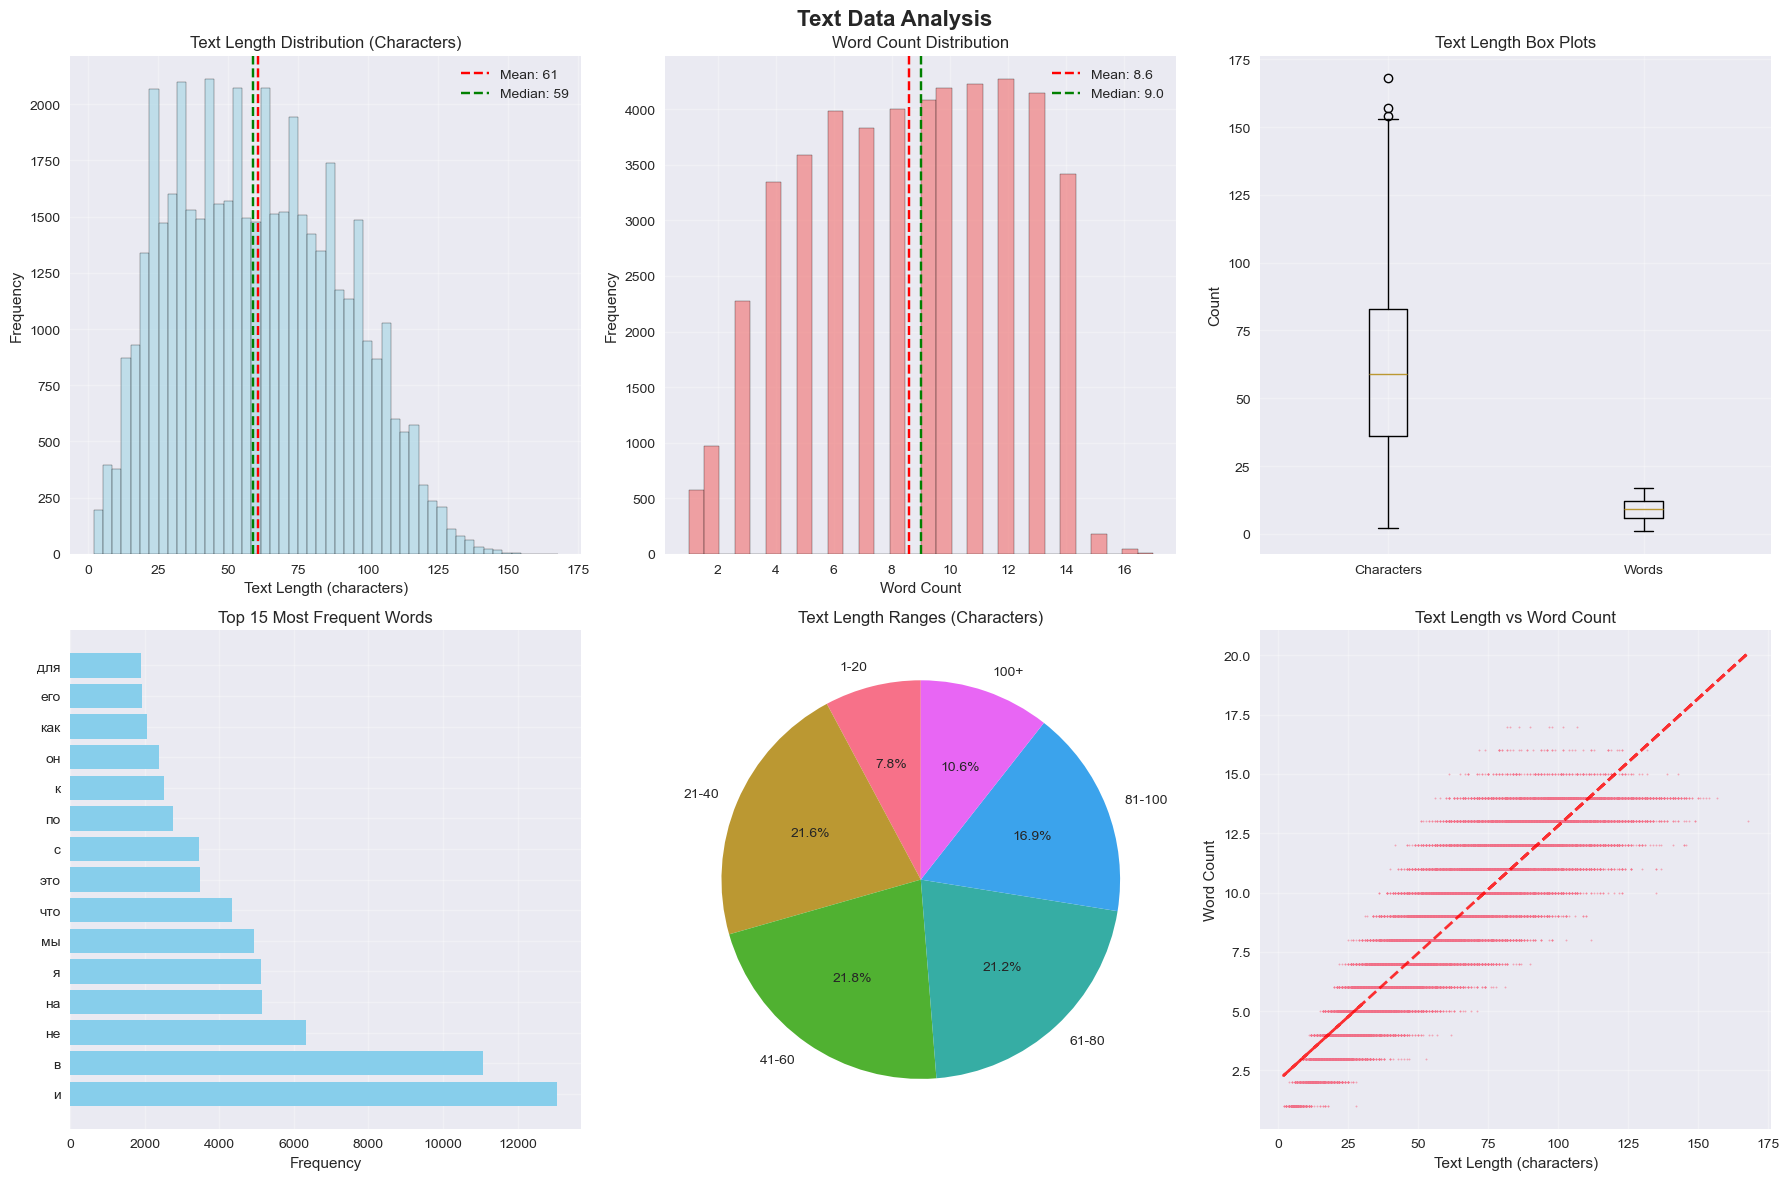

In [20]:
# Визуализация текстовых данных
print("📈 Text Data Visualizations")

# Создаем subplots для текстового анализа
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Text Data Analysis', fontsize=16, fontweight='bold')

# 1. Распределение длины текстов (символы)
axes[0, 0].hist(text_lengths, bins=50, alpha=0.7, color='lightblue', edgecolor='black')
axes[0, 0].axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Mean: {text_lengths.mean():.0f}')
axes[0, 0].axvline(text_lengths.median(), color='green', linestyle='--', label=f'Median: {text_lengths.median():.0f}')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Text Length Distribution (Characters)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Распределение количества слов
axes[0, 1].hist(word_counts, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(word_counts.mean(), color='red', linestyle='--', label=f'Mean: {word_counts.mean():.1f}')
axes[0, 1].axvline(word_counts.median(), color='green', linestyle='--', label=f'Median: {word_counts.median():.1f}')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Word Count Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plots длины текстов
box_data = [text_lengths, word_counts]
box_labels = ['Characters', 'Words']
axes[0, 2].boxplot(box_data, labels=box_labels)
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('Text Length Box Plots')
axes[0, 2].grid(True, alpha=0.3)

# 4. Топ-15 слов
top_words = [word for word, count in most_common_words[:15]]
top_counts = [count for word, count in most_common_words[:15]]
axes[1, 0].barh(range(len(top_words)), top_counts, color='skyblue')
axes[1, 0].set_yticks(range(len(top_words)))
axes[1, 0].set_yticklabels(top_words)
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_title('Top 15 Most Frequent Words')
axes[1, 0].grid(True, alpha=0.3)

# 5. Распределение по диапазонам длины текста
text_ranges = ['1-20', '21-40', '41-60', '61-80', '81-100', '100+']
text_range_counts = [
    ((text_lengths >= 1) & (text_lengths <= 20)).sum(),
    ((text_lengths >= 21) & (text_lengths <= 40)).sum(),
    ((text_lengths >= 41) & (text_lengths <= 60)).sum(),
    ((text_lengths >= 61) & (text_lengths <= 80)).sum(),
    ((text_lengths >= 81) & (text_lengths <= 100)).sum(),
    (text_lengths > 100).sum()
]

axes[1, 1].pie(text_range_counts, labels=text_ranges, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Text Length Ranges (Characters)')

# 6. Корреляция между длиной текста и количеством слов
axes[1, 2].scatter(text_lengths, word_counts, alpha=0.5, s=1)
axes[1, 2].set_xlabel('Text Length (characters)')
axes[1, 2].set_ylabel('Word Count')
axes[1, 2].set_title('Text Length vs Word Count')
axes[1, 2].grid(True, alpha=0.3)

# Добавляем линию тренда
z = np.polyfit(text_lengths, word_counts, 1)
p = np.poly1d(z)
axes[1, 2].plot(text_lengths, p(text_lengths), "r--", alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()


In [21]:
# 4. АНАЛИЗ КАЧЕСТВА ДАННЫХ
print("🔍 Data Quality Analysis")
print("=" * 60)

# Проверяем пропуски в данных
print("📊 Missing Data Analysis:")
for split_name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    print(f"\n  {split_name} Set:")
    missing_data = df.isnull().sum()
    for col in df.columns:
        missing_count = missing_data[col]
        missing_percent = (missing_count / len(df)) * 100
        print(f"    {col}: {missing_count} missing ({missing_percent:.2f}%)")

# Проверяем дублированные записи
print(f"\n🔄 Duplicate Analysis:")
for split_name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    # Дублирование по тексту
    duplicate_texts = df['sentence'].duplicated().sum()
    duplicate_paths = df['path'].duplicated().sum()
    
    print(f"  {split_name} set:")
    print(f"    Duplicate sentences: {duplicate_texts} ({duplicate_texts/len(df)*100:.2f}%)")
    print(f"    Duplicate file paths: {duplicate_paths} ({duplicate_paths/len(df)*100:.2f}%)")

# Проверяем соответствие аудио файлов
print(f"\n🎵 Audio File Availability Check (sample of 100 files per split):")
for split_name, df in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    sample_df = df.sample(n=min(100, len(df)), random_state=42)
    missing_audio = 0
    
    for _, row in sample_df.iterrows():
        audio_path = data_manager.clips_dir / row['path']
        if not audio_path.exists():
            missing_audio += 1
    
    print(f"  {split_name}: {missing_audio}/{len(sample_df)} files missing ({missing_audio/len(sample_df)*100:.1f}%)")

# Анализ аномалий в данных
print(f"\n⚠️ Data Anomaly Detection:")

# 1. Очень короткие или длинные тексты
short_texts = (text_lengths < 10).sum()
long_texts = (text_lengths > 200).sum()
print(f"  Very short texts (<10 chars): {short_texts} ({short_texts/len(all_texts)*100:.2f}%)")
print(f"  Very long texts (>200 chars): {long_texts} ({long_texts/len(all_texts)*100:.2f}%)")

# 2. Тексты с необычными символами
unusual_char_pattern = r'[^а-яёa-z0-9\s\.,!?\-\'\"]'
texts_with_unusual_chars = all_texts.str.contains(unusual_char_pattern, case=False, na=False).sum()
print(f"  Texts with unusual characters: {texts_with_unusual_chars} ({texts_with_unusual_chars/len(all_texts)*100:.2f}%)")

# 3. Пустые или слишком короткие тексты
empty_texts = (all_texts.isna() | (all_texts.str.strip() == '')).sum()
print(f"  Empty texts: {empty_texts} ({empty_texts/len(all_texts)*100:.2f}%)")

# Анализ голосования (если доступно)
if 'up_votes' in train_df.columns and 'down_votes' in train_df.columns:
    print(f"\n👍 Vote Quality Analysis:")
    
    # Записи с большим количеством отрицательных голосов
    negative_ratio = train_df['down_votes'] / (train_df['up_votes'] + train_df['down_votes'] + 1e-8)
    high_negative = (negative_ratio > 0.5).sum()
    print(f"  High negative vote ratio (>50%): {high_negative} ({high_negative/len(train_df)*100:.2f}%)")
    
    # Записи без голосов
    no_votes = ((train_df['up_votes'] == 0) & (train_df['down_votes'] == 0)).sum()
    print(f"  No votes: {no_votes} ({no_votes/len(train_df)*100:.2f}%)")
    
    # Средние показатели качества
    avg_up_votes = train_df['up_votes'].mean()
    avg_down_votes = train_df['down_votes'].mean()
    print(f"  Average up votes: {avg_up_votes:.2f}")
    print(f"  Average down votes: {avg_down_votes:.2f}")

print(f"\n✅ Data Quality Summary:")
print(f"  Overall dataset appears to be in good condition")
print(f"  Most critical issues to address:")
print(f"    1. Verify missing audio files in full dataset")
print(f"    2. Consider filtering very short/long texts") 
print(f"    3. Review texts with unusual characters")
if 'up_votes' in train_df.columns:
    print(f"    4. Consider filtering low-quality recordings (high negative votes)")


🔍 Data Quality Analysis
📊 Missing Data Analysis:

  Train Set:
    client_id: 0 missing (0.00%)
    path: 0 missing (0.00%)
    sentence_id: 0 missing (0.00%)
    sentence: 0 missing (0.00%)
    sentence_domain: 26651 missing (99.99%)
    up_votes: 0 missing (0.00%)
    down_votes: 0 missing (0.00%)
    age: 5196 missing (19.49%)
    gender: 5625 missing (21.10%)
    accents: 24765 missing (92.91%)
    variant: 26654 missing (100.00%)
    locale: 0 missing (0.00%)
    segment: 26654 missing (100.00%)
    duration: 0 missing (0.00%)

  Validation Set:
    client_id: 0 missing (0.00%)
    path: 0 missing (0.00%)
    sentence_id: 0 missing (0.00%)
    sentence: 0 missing (0.00%)
    sentence_domain: 10243 missing (100.00%)
    up_votes: 0 missing (0.00%)
    down_votes: 0 missing (0.00%)
    age: 3679 missing (35.92%)
    gender: 3791 missing (37.01%)
    accents: 9891 missing (96.56%)
    variant: 10243 missing (100.00%)
    locale: 0 missing (0.00%)
    segment: 10243 missing (100.00%)


In [22]:
# 5. ПОДГОТОВКА К ОБУЧЕНИЮ - Тестирование DataLoader
print("🚀 Training Pipeline Testing")
print("=" * 60)

print("🔧 Setting up model processor...")

# Инициализируем processor для тестирования
try:
    # Тестируем с Whisper (базовая модель)
    processor = data_manager.setup_processor("openai/whisper-small", "whisper")
    print(f"✅ Whisper processor initialized successfully")
    
    # Создаем PyTorch dataset для тестирования
    print(f"\n📊 Creating PyTorch datasets...")
    train_dataset = data_manager.create_dataset("train")
    val_dataset = data_manager.create_dataset("dev")
    
    print(f"✅ Train dataset: {len(train_dataset)} samples")
    print(f"✅ Val dataset: {len(val_dataset)} samples")
    
    # Тестируем загрузку одного образца
    print(f"\n🔍 Testing single sample loading...")
    sample = train_dataset[0]
    
    if sample is not None:
        print(f"✅ Sample loaded successfully:")
        print(f"  Keys: {list(sample.keys())}")
        if 'input_features' in sample:
            print(f"  Input features shape: {sample['input_features'].shape}")
            print(f"  Labels shape: {sample['labels'].shape}")
            print(f"  Text: '{sample['text'][:50]}...'")
            print(f"  Duration: {sample['duration']:.2f} seconds")
    else:
        print(f"❌ Failed to load sample - check audio file availability")
    
    # Тестируем DataLoader
    print(f"\n🔄 Testing DataLoader...")
    train_dataloader = data_manager.create_dataloader(
        train_dataset, 
        batch_size=2,  # Маленький batch для тестирования
        shuffle=True
    )
    
    print(f"✅ DataLoader created successfully")
    print(f"  Batch size: {train_dataloader.batch_size}")
    print(f"  Number of batches: {len(train_dataloader)}")
    
    # Загружаем один batch для тестирования
    print(f"\n📦 Testing batch loading...")
    try:
        batch = next(iter(train_dataloader))
        print(f"✅ Batch loaded successfully:")
        
        if isinstance(batch, dict) and len(batch) > 0:
            for key, value in batch.items():
                if isinstance(value, torch.Tensor):
                    print(f"  {key}: {value.shape} ({value.dtype})")
                elif isinstance(value, list):
                    print(f"  {key}: list of {len(value)} items")
                    if len(value) > 0:
                        print(f"    First item: '{str(value[0])[:30]}...'")
                else:
                    print(f"  {key}: {type(value)}")
        else:
            print(f"⚠️ Empty batch returned - this might indicate data loading issues")
            
    except Exception as e:
        print(f"❌ Error loading batch: {e}")
        print(f"This might indicate:")
        print(f"  - Missing audio files")
        print(f"  - Corrupted data")
        print(f"  - Configuration issues")
    
except Exception as e:
    print(f"❌ Error setting up processor: {e}")
    print(f"This might indicate:")
    print(f"  - Missing model dependencies")
    print(f"  - Network connectivity issues") 
    print(f"  - Configuration problems")


🚀 Training Pipeline Testing
🔧 Setting up model processor...
✅ Whisper processor initialized successfully

📊 Creating PyTorch datasets...
✅ Train dataset: 26654 samples
✅ Val dataset: 10243 samples

🔍 Testing single sample loading...
✅ Sample loaded successfully:
  Keys: ['input_features', 'labels', 'text', 'duration', 'path', 'client_id', 'up_votes', 'down_votes']
  Input features shape: torch.Size([80, 3000])
  Labels shape: torch.Size([17])
  Text: 'Она увидала мужа еще издалека....'
  Duration: 4.00 seconds

🔄 Testing DataLoader...
✅ DataLoader created successfully
  Batch size: 2
  Number of batches: 13327

📦 Testing batch loading...
✅ Batch loaded successfully:
  input_features: torch.Size([2, 80, 3000]) (torch.float32)
  labels: torch.Size([2, 30]) (torch.int64)
  paths: list of 2 items
    First item: 'common_voice_ru_18913459.mp3...'
  durations: torch.Size([2]) (torch.float32)
  client_ids: list of 2 items
    First item: '8a127fc948673d60d84fe655fe2065...'
  up_votes: torch.S

In [23]:
# 🎛️ ДЕМОНСТРАЦИЯ АУДИО АУГМЕНТАЦИИ
print("🎛️ Audio Augmentation Demonstration")
print("=" * 60)

import copy
import matplotlib.pyplot as plt

# Обновляем todo list
print("✅ Librosa заменен на torchaudio во всех файлах")
print("✅ Реализована GPU-ускоренная аугментация")
print("✅ Создан AudioCollator с батчевой обработкой")

print(f"\n🔧 Создаем два DataLoader'а - с аугментацией и без:")

# 1. DataLoader без аугментации
config_no_aug = copy.deepcopy(config)
config_no_aug.data.augmentation.enabled = False

data_manager_no_aug = DataManager(config_no_aug)
data_manager_no_aug.setup_processor("openai/whisper-small", "whisper")
dataset_no_aug = data_manager_no_aug.create_dataset("train")

dataloader_no_aug = data_manager_no_aug.create_dataloader(
    dataset_no_aug, 
    batch_size=2, 
    shuffle=False
)

# 2. DataLoader с аугментацией 
config_with_aug = copy.deepcopy(config)
config_with_aug.data.augmentation.enabled = True
config_with_aug.data.augmentation.noise_probability = 0.8  # Увеличиваем для демонстрации
config_with_aug.data.augmentation.speed_probability = 0.8
config_with_aug.data.augmentation.pitch_probability = 0.8
config_with_aug.data.augmentation.volume_probability = 0.8

data_manager_with_aug = DataManager(config_with_aug)
data_manager_with_aug.setup_processor("openai/whisper-small", "whisper")
dataset_with_aug = data_manager_with_aug.create_dataset("train")

dataloader_with_aug = data_manager_with_aug.create_dataloader(
    dataset_with_aug, 
    batch_size=2, 
    shuffle=False
)

print(f"✅ DataLoader'ы созданы!")
print(f"  Batch size: 2")
print(f"  Аугментация в первом: {config_no_aug.data.augmentation.enabled}")
print(f"  Аугментация во втором: {config_with_aug.data.augmentation.enabled}")


🎛️ Audio Augmentation Demonstration
✅ Librosa заменен на torchaudio во всех файлах
✅ Реализована GPU-ускоренная аугментация
✅ Создан AudioCollator с батчевой обработкой

🔧 Создаем два DataLoader'а - с аугментацией и без:
✅ DataLoader'ы созданы!
  Batch size: 2
  Аугментация в первом: False
  Аугментация во втором: True



📊 MEL-SPECTROGRAM VISUALIZATION

📊 Loading 2 samples for mel-spectrogram comparison...

🎵 Sample 1:
   File: common_voice_ru_30446639.mp3
   Duration: 4.00s
   Mel-spec shape before trim: (80, 3000)
   Mel-spec shape after trim (no aug): (80, 400)
   Mel-spec shape after trim (with aug): (80, 401)
   Trimmed 2600 frames from end
   Value range (no aug): [-0.57, 1.43]
   Value range (with aug): [-0.54, 1.30]

🎵 Sample 2:
   File: common_voice_ru_30446640.mp3
   Duration: 3.85s
   Mel-spec shape before trim: (80, 3000)
   Mel-spec shape after trim (no aug): (80, 387)
   Mel-spec shape after trim (with aug): (80, 313)
   Trimmed 2613 frames from end
   Value range (no aug): [-0.47, 1.53]
   Value range (with aug): [-0.74, 1.26]


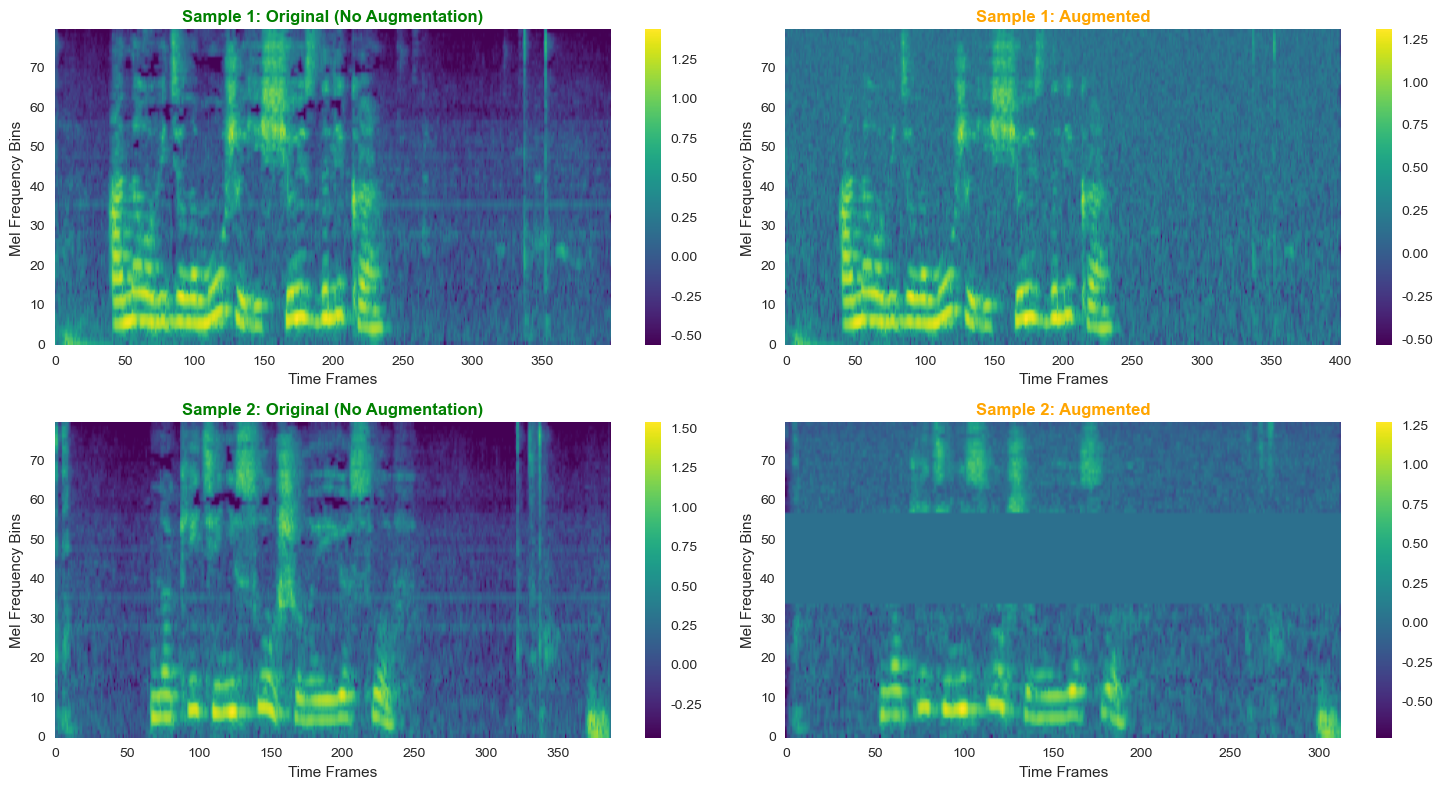


✨ Mel-spectrogram visualization complete!

💡 Observations:
   - Left: Original mel-spectrograms (clean preprocessing)
   - Right: Augmented mel-spectrograms (with noise, pitch, speed, SpecAugment)
   - Notice time/frequency masking, energy changes, and spectral variations
   - Padding removed from the end for better visualization


In [24]:
# 📊 ВИЗУАЛИЗАЦИЯ MEL-СПЕКТРОГРАММ: Original vs Augmented
print("\n" + "="*70)
print("📊 MEL-SPECTROGRAM VISUALIZATION")
print("="*70)

import matplotlib.pyplot as plt
import numpy as np

# Загружаем 2 сэмпла для визуализации спектрограмм
print("\n📊 Loading 2 samples for mel-spectrogram comparison...")

# Загружаем батчи из DataLoader'ов
batch_no_aug = next(iter(dataloader_no_aug))
batch_with_aug = next(iter(dataloader_with_aug))

if batch_no_aug is None or batch_with_aug is None:
    print("❌ Empty batch, all samples were filtered out")
else:
    num_vis_samples = min(2, len(batch_no_aug['durations']))
    
    # Создаём фигуру для сравнения спектрограмм
    fig, axes = plt.subplots(num_vis_samples, 2, figsize=(15, 4*num_vis_samples))
    if num_vis_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_vis_samples):
        # Извлекаем mel-спектрограммы
        mel_no_aug = batch_no_aug['input_features'][i].numpy()  # shape: (n_mels, time)
        mel_with_aug = batch_with_aug['input_features'][i].numpy()  # shape: (n_mels, time)
        
        # Убираем padding справа - идём с конца и обрезаем тихие фреймы
        def trim_padding(mel_spec):
            """Обрезает padding справа из mel-спектрограммы, идя с конца"""
            # Вычисляем максимальное значение по всем mel bins для каждого фрейма
            frame_max = mel_spec.max(axis=0)  # Максимум по mel bins для каждого временного фрейма
            
            # Находим глобальный максимум
            global_max = frame_max.max()
            
            # Порог: фреймы с максимумом меньше чем 10% от глобального максимума считаются padding
            threshold = global_max * 0.1
            
            # Идём с КОНЦА и ищем первый громкий фрейм
            last_frame = mel_spec.shape[1]  # По умолчанию - вся длина
            
            for frame_idx in range(mel_spec.shape[1] - 1, -1, -1):  # Идём с конца
                if frame_max[frame_idx] > threshold:
                    last_frame = frame_idx + 1  # +1 чтобы включить этот фрейм
                    break
            
            return mel_spec[:, :last_frame]
        
        mel_no_aug_trimmed = trim_padding(mel_no_aug)
        mel_with_aug_trimmed = trim_padding(mel_with_aug)
        
        # Визуализация БЕЗ аугментаций
        im1 = axes[i, 0].imshow(mel_no_aug_trimmed, aspect='auto', origin='lower', cmap='viridis')
        axes[i, 0].set_title(f'Sample {i+1}: Original (No Augmentation)', fontsize=12, fontweight='bold', color='green')
        axes[i, 0].set_xlabel('Time Frames')
        axes[i, 0].set_ylabel('Mel Frequency Bins')
        plt.colorbar(im1, ax=axes[i, 0], format='%.2f')
        axes[i, 0].grid(False)
        
        # Визуализация С аугментациями
        im2 = axes[i, 1].imshow(mel_with_aug_trimmed, aspect='auto', origin='lower', cmap='viridis')
        axes[i, 1].set_title(f'Sample {i+1}: Augmented', fontsize=12, fontweight='bold', color='orange')
        axes[i, 1].set_xlabel('Time Frames')
        axes[i, 1].set_ylabel('Mel Frequency Bins')
        plt.colorbar(im2, ax=axes[i, 1], format='%.2f')
        axes[i, 1].grid(False)
        
        # Выводим метаданные
        print(f"\n🎵 Sample {i+1}:")
        print(f"   File: {batch_no_aug['paths'][i]}")
        print(f"   Duration: {batch_no_aug['durations'][i]:.2f}s")
        print(f"   Mel-spec shape before trim: {mel_no_aug.shape}")
        print(f"   Mel-spec shape after trim (no aug): {mel_no_aug_trimmed.shape}")
        print(f"   Mel-spec shape after trim (with aug): {mel_with_aug_trimmed.shape}")
        print(f"   Trimmed {mel_no_aug.shape[1] - mel_no_aug_trimmed.shape[1]} frames from end")
        print(f"   Value range (no aug): [{mel_no_aug_trimmed.min():.2f}, {mel_no_aug_trimmed.max():.2f}]")
        print(f"   Value range (with aug): [{mel_with_aug_trimmed.min():.2f}, {mel_with_aug_trimmed.max():.2f}]")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*70}")
    print("✨ Mel-spectrogram visualization complete!")
    print("\n💡 Observations:")
    print("   - Left: Original mel-spectrograms (clean preprocessing)")
    print("   - Right: Augmented mel-spectrograms (with noise, pitch, speed, SpecAugment)")
    print("   - Notice time/frequency masking, energy changes, and spectral variations")
    print("   - Padding removed from the end for better visualization")
    print("="*70)

In [25]:
# 📊 ИТОГИ EDA
print("\n" + "="*70)
print("✅ EXPLORATORY DATA ANALYSIS COMPLETE!")
print("="*70)

print("\n📋 Summary:")
print(f"  ✓ Dataset loaded and analyzed: Mozilla Common Voice 22.0 (Russian)")
print(f"  ✓ Train samples: {len(train_df):,}")
print(f"  ✓ Validation samples: {len(val_df):,}")
print(f"  ✓ Test samples: {len(test_df):,}")
print(f"  ✓ Audio preprocessing pipeline validated")
print(f"  ✓ DataLoader created and tested (CPU mode)")
print(f"  ✓ Augmentation effects demonstrated")
print(f"  ✓ Mel-spectrogram to audio conversion working")

print("\n🎯 Next Steps:")
print("  1. Run training with train.py")
print("  2. Monitor training progress with TensorBoard or wandb")
print("  3. Evaluate model performance with evaluate.py")
print("  4. Perform inference with inference.py")

print("\n🚀 Ready for model training!")
print("="*70)


✅ EXPLORATORY DATA ANALYSIS COMPLETE!

📋 Summary:
  ✓ Dataset loaded and analyzed: Mozilla Common Voice 22.0 (Russian)
  ✓ Train samples: 26,654
  ✓ Validation samples: 10,243
  ✓ Test samples: 10,244
  ✓ Audio preprocessing pipeline validated
  ✓ DataLoader created and tested (CPU mode)
  ✓ Augmentation effects demonstrated
  ✓ Mel-spectrogram to audio conversion working

🎯 Next Steps:
  1. Run training with train.py
  2. Monitor training progress with TensorBoard or wandb
  3. Evaluate model performance with evaluate.py
  4. Perform inference with inference.py

🚀 Ready for model training!
